# Routing optical and RF ports

Optical and high speed RF ports have an orientation that routes need to follow to avoid sharp turns that produce reflections.

In [1]:
import gdsfactory as gf

gf.config.set_plot_options(show_subports=False)
gf.CONF.plotter = "matplotlib"

2022-04-29 12:47:28.683 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.3.4


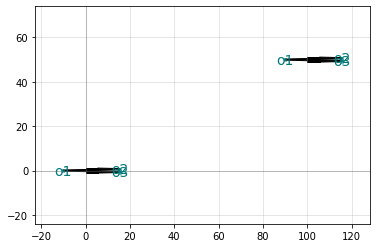

In [2]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
c.plot()

## get_route

`get_route` returns a Manhattan route between 2 ports

In [3]:
gf.routing.get_route?

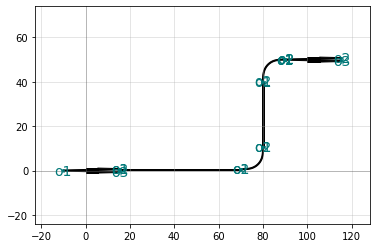

In [4]:
c = gf.Component("sample_connect")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o1"])
c.add(route.references)
c.plot()

In [5]:
route

Route(references=[DeviceReference (parent Device "bend_euler_9e0718a0", ports ['o1', 'o2'], origin [69.99   0.625], rotation 0, x_reflection False), DeviceReference (parent Device "bend_euler_9e0718a0", ports ['o1', 'o2'], origin [79.99 40.  ], rotation 90.0, x_reflection True), DeviceReference (parent Device "straight_206dab3e", ports ['o1', 'o2'], origin [15.5    0.625], rotation 0, x_reflection False), DeviceReference (parent Device "straight_430a640a", ports ['o1', 'o2'], origin [79.99  10.625], rotation 90.0, x_reflection False), DeviceReference (parent Device "straight_4ae164bc", ports ['o1', 'o2'], origin [89.99 50.  ], rotation 0, x_reflection False)], labels=None, ports=(Port (name o1, midpoint [15.5    0.625], width 0.5, orientation 180, layer (1, 0), port_type optical), Port (name o2, midpoint [90. 50.], width 0.5, orientation 0.0, layer (1, 0), port_type optical)), length=117.149)

**Connect strip: Problem**

sometimes there are obstacles that connect strip does not see!

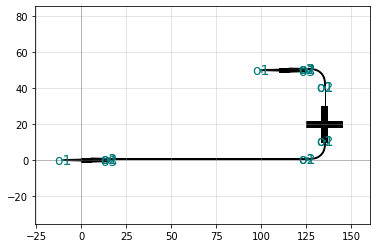

In [6]:
c = gf.Component("sample_problem")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))
x = c << gf.components.cross(length=20)
x.move((135, 20))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o2"])
c.add(route.references)
c.plot()

**Solution: Connect strip way points**

You can also specify the points along the route

In [7]:
gf.routing.get_route_waypoints?

Object `gf.routing.get_route_waypoints` not found.


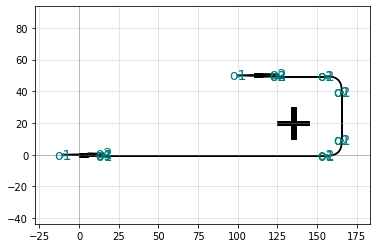

In [8]:
c = gf.Component("sample_avoid_obstacle")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))
x = c << gf.components.cross(length=20)
x.move((135, 20))

x0 = mmi1.ports["o3"].x
y0 = mmi1.ports["o3"].y


x2 = mmi2.ports["o3"].x
y2 = mmi2.ports["o3"].y

route = gf.routing.get_route_from_waypoints(
    [(x0, y0), (x2 + 40, y0), (x2 + 40, y2), (x2, y2)]
)
c.add(route.references)
c.plot()

In [9]:
route.length

233.274

In [10]:
route.ports

(Port (name o1, midpoint [15.5   -0.625], width 0.5, orientation 180, layer (1, 0), port_type optical),
 Port (name o2, midpoint [125.5    49.375], width 0.5, orientation 180.0, layer (1, 0), port_type optical))

In [11]:
route.references

[DeviceReference (parent Device "bend_euler_9e0718a0", ports ['o1', 'o2'], origin [155.5    -0.625], rotation 0, x_reflection False),
 DeviceReference (parent Device "bend_euler_9e0718a0", ports ['o1', 'o2'], origin [165.5    39.375], rotation 90, x_reflection False),
 DeviceReference (parent Device "straight_29077142", ports ['o1', 'o2'], origin [15.5   -0.625], rotation 0, x_reflection False),
 DeviceReference (parent Device "straight_a065fbc7", ports ['o1', 'o2'], origin [165.5     9.375], rotation 90.0, x_reflection False),
 DeviceReference (parent Device "straight_a065fbc7", ports ['o1', 'o2'], origin [155.5    49.375], rotation 180.0, x_reflection False)]

Lets say that we want to extrude the waveguide using a different waveguide crosssection, for example using a different layer

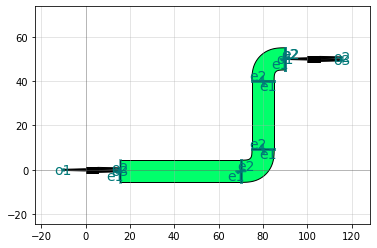

In [12]:
import gdsfactory as gf

c = gf.Component("sample_connect")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.get_route(
    mmi1.ports["o3"], mmi2.ports["o1"], cross_section=gf.cross_section.metal1
)
c.add(route.references)
c.plot()

## auto-widen

To reduce loss and phase errors you can also auto-widen waveguide routes straight sections that are longer than a certain length.

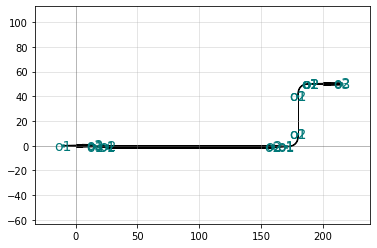

In [13]:
import gdsfactory as gf

c = gf.Component("sample_connect")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((200, 50))
route = gf.routing.get_route(
    mmi1.ports["o3"],
    mmi2.ports["o1"],
    cross_section=gf.cross_section.strip,
    auto_widen=True,
    width_wide=2,
    auto_widen_minimum_length=100,
)
c.add(route.references)
c.plot()

## get_route_from_waypoints

Sometimes you need to set up a route with custom waypoints. `get_route_from_waypoints` is a manual version of `get_route`

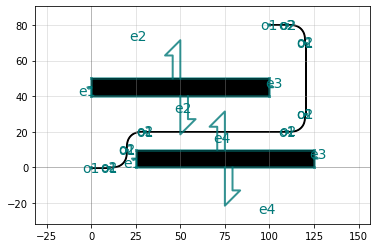

In [14]:
import gdsfactory as gf

c = gf.Component("waypoints_sample")

w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25


p0x, p0y = left.ports["o2"].midpoint
p1x, p1y = right.ports["o2"].midpoint
o = 10  # vertical offset to overcome bottom obstacle
ytop = 20


routes = gf.routing.get_route_from_waypoints(
    [
        (p0x, p0y),
        (p0x + o, p0y),
        (p0x + o, ytop),
        (p1x + o, ytop),
        (p1x + o, p1y),
        (p1x, p1y),
    ],
)
c.add(routes.references)
c.plot()

## get_route_from_steps

As you can see waypoints can only change one point (x or y) at a time, making the waypoint definition a bit redundant.

You can also use a `get_route_from_steps` which is a more concise route definition, that supports defining only the new steps `x` or `y` together with increments `dx` or `dy`

`get_route_from_steps` is a manual version of `get_route` and a more concise and convenient version of `get_route_from_waypoints`

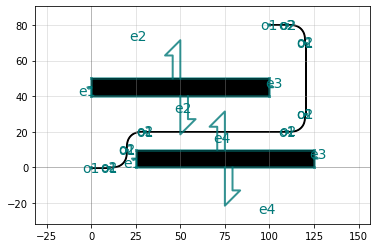

In [15]:
import gdsfactory as gf

c = gf.Component("get_route_from_steps")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20, "y": 0},
        {"x": 20, "y": 20},
        {"x": 120, "y": 20},
        {"x": 120, "y": 80},
    ],
)
c.add(routes.references)
c.plot()

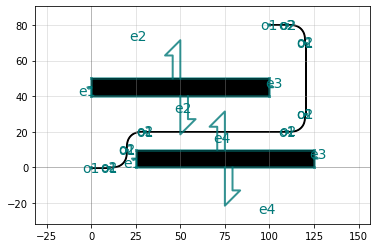

In [16]:
import gdsfactory as gf

c = gf.Component("get_route_from_steps_shorter_syntax")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20},
        {"y": 20},
        {"x": 120},
        {"y": 80},
    ],
)
c.add(routes.references)
c.plot()

## get_bundle

**Problem**

See the route collisions When connecting groups of ports using a regular manhattan single-route router  such as `get route`

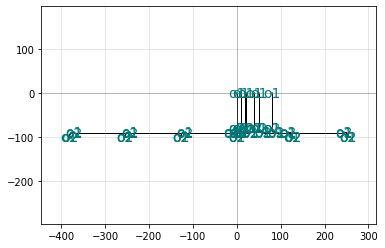

In [17]:
import gdsfactory as gf

xs_top = [0, 10, 20, 40, 50, 80]
pitch = 127
N = len(xs_top)
xs_bottom = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

top_ports = [
    gf.Port(f"top_{i}", (xs_top[i], 0), 0.5, 270, layer=layer) for i in range(N)
]

bottom_ports = [
    gf.Port(f"bottom_{i}", (xs_bottom[i], -100), 0.5, 90, layer=layer) for i in range(N)
]

c = gf.Component(name="connect_bundle")

for p1, p2 in zip(top_ports, bottom_ports):
    route = gf.routing.get_route(p1, p2)
    c.add(route.references)

c.plot()
c.show()

**solution**

`get_bundle` provides you with river routing capabilities, that you can use to route bundles of ports without collisions

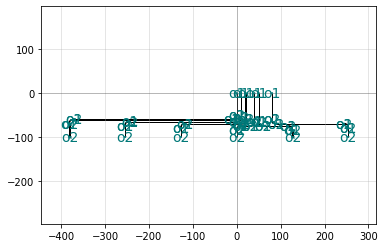

In [18]:
c = gf.Component(name="connect_bundle")
routes = gf.routing.get_bundle(top_ports, bottom_ports)
for route in routes:
    c.add(route.references)

c.plot()
c.show()

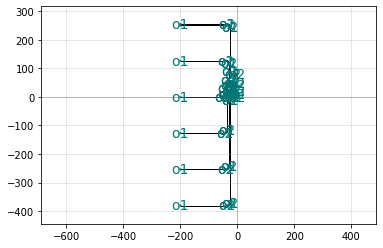

In [19]:
import gdsfactory as gf

ys_right = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(ys_right)
ys_left = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", (0, ys_right[i]), width=0.5, orientation=180, layer=layer)
    for i in range(N)
]
left_ports = [
    gf.Port(
        f"L_{i}".format(i), (-200, ys_left[i]), width=0.5, orientation=0, layer=layer
    )
    for i in range(N)
]

# you can also mess up the port order and it will sort them by default
left_ports.reverse()

c = gf.Component(name="connect_bundle2")
routes = gf.routing.get_bundle(
    left_ports, right_ports, sort_ports=True, start_straight_length=100
)
for route in routes:
    c.add(route.references)
c.plot()

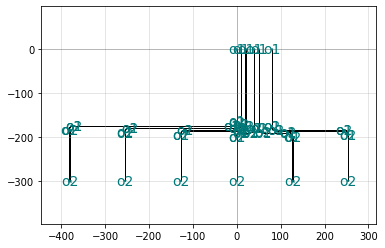

In [20]:
xs_top = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(xs_top)
xs_bottom = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

top_ports = [
    gf.Port(
        f"top_{i}", midpoint=(xs_top[i], 0), width=0.5, orientation=270, layer=layer
    )
    for i in range(N)
]

bot_ports = [
    gf.Port(
        f"bot_{i}",
        midpoint=(xs_bottom[i], -300),
        width=0.5,
        orientation=90,
        layer=layer,
    )
    for i in range(N)
]

c = gf.Component(name="connect_bundle")
routes = gf.routing.get_bundle(
    top_ports, bot_ports, separation=5.0, end_straight_length=100
)
for route in routes:
    c.add(route.references)

c.plot()

`get_bundle` can also route bundles through corners

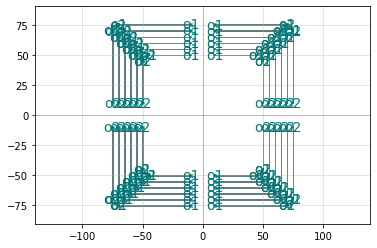

In [21]:
import gdsfactory as gf
from gdsfactory.cell import cell
from gdsfactory.component import Component
from gdsfactory.port import Port


@cell
def test_connect_corner(N=6, config="A"):
    d = 10.0
    sep = 5.0
    top_cell = gf.Component(name="connect_corner")
    layer = (1, 0)

    if config in ["A", "B"]:
        a = 100.0
        ports_A_TR = [
            Port(
                "A_TR_{}".format(i),
                midpoint=(d, a / 2 + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_A_TL = [
            Port(
                "A_TL_{}".format(i),
                midpoint=(-d, a / 2 + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_A_BR = [
            Port(
                "A_BR_{}".format(i),
                midpoint=(d, -a / 2 - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_A_BL = [
            Port(
                "A_BL_{}".format(i),
                midpoint=(-d, -a / 2 - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                "B_TR_{}".format(i),
                midpoint=(a / 2 + i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_B_TL = [
            Port(
                "B_TL_{}".format(i),
                midpoint=(-a / 2 - i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_B_BR = [
            Port(
                "B_BR_{}".format(i),
                midpoint=(a / 2 + i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_B_BL = [
            Port(
                "B_BL_{}".format(i),
                midpoint=(-a / 2 - i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    elif config in ["C", "D"]:
        a = N * sep + 2 * d
        ports_A_TR = [
            Port(
                "A_TR_{}".format(i),
                midpoint=(a, d + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_A_TL = [
            Port(
                "A_TL_{}".format(i),
                midpoint=(-a, d + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_A_BR = [
            Port(
                "A_BR_{}".format(i),
                midpoint=(a, -d - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_A_BL = [
            Port(
                "A_BL_{}".format(i),
                midpoint=(-a, -d - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                "B_TR_{}".format(i),
                midpoint=(d + i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_B_TL = [
            Port(
                "B_TL_{}".format(i),
                midpoint=(-d - i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_B_BR = [
            Port(
                "B_BR_{}".format(i),
                midpoint=(d + i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]
        ports_B_BL = [
            Port(
                "B_BL_{}".format(i),
                midpoint=(-d - i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    if config in ["A", "C"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports1, ports2, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    elif config in ["B", "D"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports2, ports1, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    return top_cell


c = test_connect_corner(config="A")
c.plot()

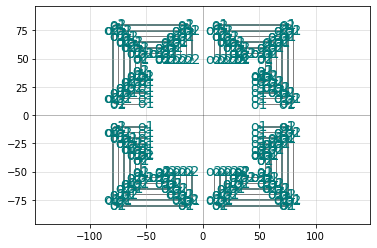

In [22]:
c = test_connect_corner(config="C")
c.plot()

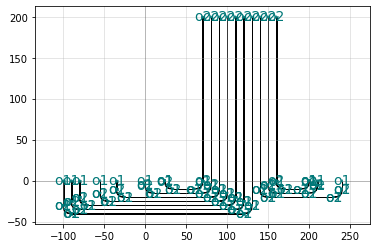

In [23]:
@cell
def test_connect_bundle_udirect(dy=200, angle=270, layer=(1, 0)):

    xs1 = [-100, -90, -80, -55, -35, 24, 0] + [200, 210, 240]

    axis = "X" if angle in [0, 180] else "Y"

    pitch = 10.0
    N = len(xs1)
    xs2 = [70 + i * pitch for i in range(N)]

    if axis == "X":
        ports1 = [
            Port(f"top_{i}", (0, xs1[i]), 0.5, angle, layer=layer) for i in range(N)
        ]

        ports2 = [
            Port(f"bottom_{i}", (dy, xs2[i]), 0.5, angle, layer=layer) for i in range(N)
        ]

    else:
        ports1 = [
            Port(f"top_{i}", (xs1[i], 0), 0.5, angle, layer=layer) for i in range(N)
        ]

        ports2 = [
            Port(f"bottom_{i}", (xs2[i], dy), 0.5, angle, layer=layer) for i in range(N)
        ]

    top_cell = Component(name="connect_bundle_udirect")
    routes = gf.routing.get_bundle(ports1, ports2, radius=10.0)
    for route in routes:
        top_cell.add(route.references)

    return top_cell


c = test_connect_bundle_udirect()
c.plot()

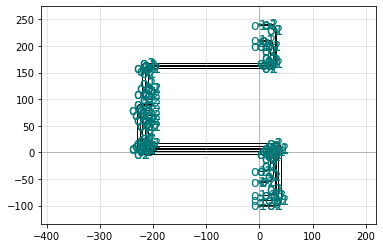

In [24]:
@cell
def test_connect_bundle_u_indirect(dy=-200, angle=180, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35] + [200, 210, 240]
    axis = "X" if angle in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [50 + i * pitch for i in range(N)]

    a1 = angle
    a2 = a1 + 180

    if axis == "X":
        ports1 = [
            Port("top_{}".format(i), (0, xs1[i]), 0.5, a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port("bot_{}".format(i), (dy, xs2[i]), 0.5, a2, layer=layer)
            for i in range(N)
        ]

    else:
        ports1 = [
            Port("top_{}".format(i), (xs1[i], 0), 0.5, a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port("bot_{}".format(i), (xs2[i], dy), 0.5, a2, layer=layer)
            for i in range(N)
        ]

    top_cell = Component("connect_bundle_u_indirect")
    routes = gf.routing.get_bundle(
        ports1,
        ports2,
        bend=gf.components.bend_euler,
        radius=10,
    )
    for route in routes:
        top_cell.add(route.references)

    return top_cell


c = test_connect_bundle_u_indirect(angle=0)
c.plot()

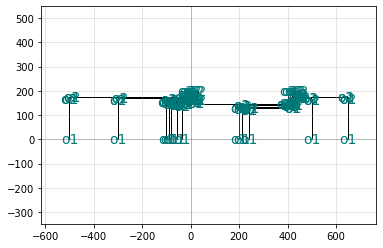

In [25]:
import gdsfactory as gf


@gf.cell
def test_north_to_south(layer=(1, 0)):
    dy = 200.0
    xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

    pitch = 10.0
    N = len(xs1)
    xs2 = [-20 + i * pitch for i in range(N // 2)]
    xs2 += [400 + i * pitch for i in range(N // 2)]

    a1 = 90
    a2 = a1 + 180

    ports1 = [
        gf.Port("top_{}".format(i), (xs1[i], 0), 0.5, a1, layer=layer) for i in range(N)
    ]
    ports2 = [
        gf.Port("bot_{}".format(i), (xs2[i], dy), 0.5, a2, layer=layer)
        for i in range(N)
    ]

    c = gf.Component()
    routes = gf.routing.get_bundle(ports1, ports2, auto_widen=False)
    for route in routes:
        c.add(route.references)

    return c


c = test_north_to_south()
c.plot()

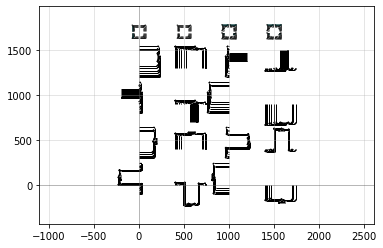

In [26]:
def demo_connect_bundle():
    """combines all the connect_bundle tests"""
    y = 400.0
    x = 500
    y0 = 900
    dy = 200.0
    c = Component("connect_bundle")
    for j, s in enumerate([-1, 1]):
        for i, angle in enumerate([0, 90, 180, 270]):
            _cmp = test_connect_bundle_u_indirect(dy=s * dy, angle=angle)
            _cmp_ref = _cmp.ref(position=(i * x, j * y))
            c.add(_cmp_ref)

            _cmp = test_connect_bundle_udirect(dy=s * dy, angle=angle)
            _cmp_ref = _cmp.ref(position=(i * x, j * y + y0))
            c.add(_cmp_ref)

    for i, config in enumerate(["A", "B", "C", "D"]):
        _cmp = test_connect_corner(config=config)
        _cmp_ref = _cmp.ref(position=(i * x, 1700))
        c.add(_cmp_ref)

    # _cmp = test_facing_ports()
    # _cmp_ref = _cmp.ref(position=(800, 1820))
    # c.add(_cmp_ref)

    return c


c = demo_connect_bundle()
c.plot()

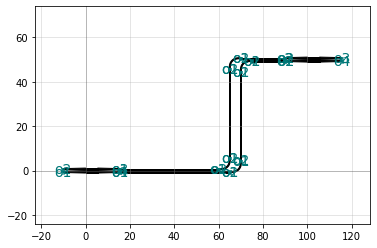

In [27]:
import gdsfactory as gf

c = gf.Component("route_bend_5um")
c1 = c << gf.components.mmi2x2()
c2 = c << gf.components.mmi2x2()

c2.move((100, 50))
routes = gf.routing.get_bundle(
    [c1.ports["o4"], c1.ports["o3"]], [c2.ports["o1"], c2.ports["o2"]], radius=5
)
for route in routes:
    c.add(route.references)
c.plot()

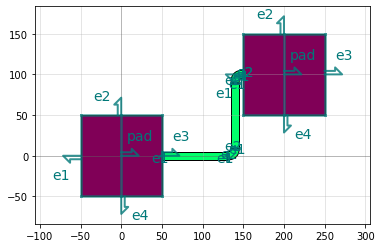

In [28]:
import gdsfactory as gf

c = gf.Component("electrical")
c1 = c << gf.components.pad()
c2 = c << gf.components.pad()
c2.move((200, 100))
routes = gf.routing.get_bundle(
    [c1.ports["e3"]], [c2.ports["e1"]], cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c.plot()

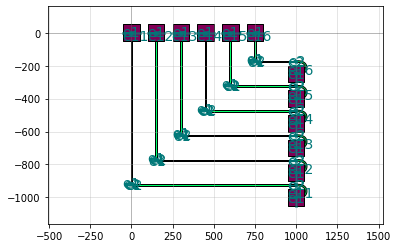

In [29]:
c = gf.Component("get_bundle_with_ubends_bend_from_top")
pad_array = gf.components.pad_array()

c1 = c << pad_array
c2 = c << pad_array
c2.rotate(90)
c2.movex(1000)
c2.ymax = -200

routes_bend180 = gf.routing.get_routes_bend180(
    ports=c2.get_ports_list(),
    radius=75 / 2,
    cross_section=gf.cross_section.metal1,
    bend_port1="e1",
    bend_port2="e2",
)
c.add(routes_bend180.references)

routes = gf.routing.get_bundle(
    c1.get_ports_list(), routes_bend180.ports, cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c.plot()

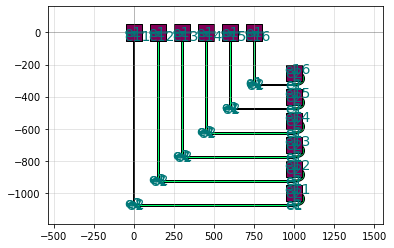

In [30]:
c = gf.Component("get_bundle_with_ubends_bend_from_bottom")
pad_array = gf.components.pad_array()

c1 = c << pad_array
c2 = c << pad_array
c2.rotate(90)
c2.movex(1000)
c2.ymax = -200

routes_bend180 = gf.routing.get_routes_bend180(
    ports=c2.get_ports_list(),
    radius=75 / 2,
    cross_section=gf.cross_section.metal1,
    bend_port1="e2",
    bend_port2="e1",
)
c.add(routes_bend180.references)

routes = gf.routing.get_bundle(
    c1.get_ports_list(), routes_bend180.ports, cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c.plot()

**Problem**

Sometimes 90 degrees routes do not have enough space for a Manhattan route

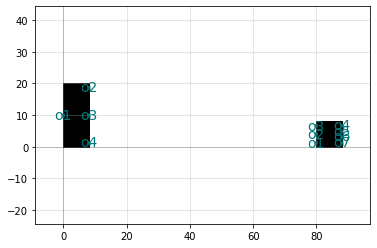

In [31]:
import gdsfactory as gf

c = gf.Component("route_fail_1")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
c.plot()

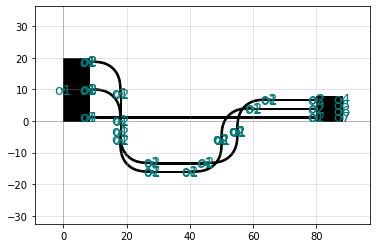

In [32]:
import gdsfactory as gf

c = gf.Component("route_fail_1")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    auto_widen=False,
)
for route in routes:
    c.add(route.references)
c.plot()

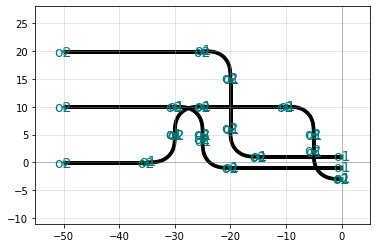

In [33]:
c = gf.Component("route_fail_2")
pitch = 2.0
ys_left = [0, 10, 20]
N = len(ys_left)
ys_right = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", (0, ys_right[i]), 0.5, 180, layer=layer) for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", (-50, ys_left[i]), 0.5, 0, layer=layer) for i in range(N)
]
left_ports.reverse()
routes = gf.routing.get_bundle(right_ports, left_ports, radius=5)

for i, route in enumerate(routes):
    c.add(route.references)
c.plot()

**Solution**

Add Sbend routes using `get_bundle_sbend`

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/components/bezier.py:106: RuntimeWarning: divide by zero encountered in double_scalars
  min_bend_radius = gf.snap.snap_to_grid(1 / max(np.abs(curv)))


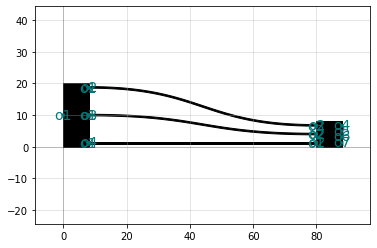

In [34]:
import gdsfactory as gf

c = gf.Component("route_solution_1_get_bundle_sbend")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle_sbend(
    c1.get_ports_list(orientation=0), c2.get_ports_list(orientation=180)
)
c.add(routes.references)
c.plot()

In [35]:
routes

Routes(references=[DeviceReference (parent Device "bezier_150a4736_bend_s_e3a1bb7b", ports ['o1', 'o2'], origin [8.   1.25], rotation 0, x_reflection False), DeviceReference (parent Device "bezier_6e86074d_bend_s_6340bc13", ports ['o1', 'o2'], origin [ 8. 10.], rotation 0, x_reflection False), DeviceReference (parent Device "bezier_7fa76591_bend_s_7425fec2", ports ['o1', 'o2'], origin [ 8.   18.75], rotation 0, x_reflection False)], lengths=[72.0, 72.354, 73.398], ports=None, bend_radius=[inf, 159.432, 83.82])

In [36]:
c = gf.Component("route_solution_2_get_bundle_sbend")
route = gf.routing.get_bundle_sbend(right_ports, left_ports)
c.add(route.references)

## get_bundle_from_waypoints

While `get_bundle` routes bundles of ports automatically, you can also use `get_bundle_from_waypoints` to manually specify the route waypoints.

You can think of `get_bundle_from_waypoints` as a manual version of `get_bundle`


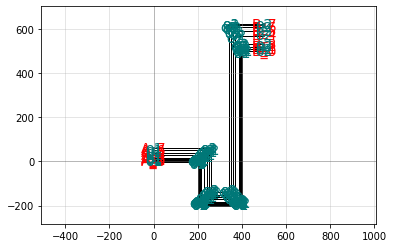

In [37]:
import numpy as np
import gdsfactory as gf


@gf.cell
def test_connect_bundle_waypoints(layer=(1, 0)):
    """Connect bundle of ports with bundle of routes following a list of waypoints."""
    ys1 = np.array([0, 5, 10, 15, 30, 40, 50, 60]) + 0.0
    ys2 = np.array([0, 10, 20, 30, 70, 90, 110, 120]) + 500.0
    N = ys1.size

    ports1 = [
        gf.Port(
            name=f"A_{i}", midpoint=(0, ys1[i]), width=0.5, orientation=0, layer=layer
        )
        for i in range(N)
    ]
    ports2 = [
        gf.Port(
            name=f"B_{i}",
            midpoint=(500, ys2[i]),
            width=0.5,
            orientation=180,
            layer=layer,
        )
        for i in range(N)
    ]

    p0 = ports1[0].position

    c = gf.Component("B")
    c.add_ports(ports1)
    c.add_ports(ports2)
    waypoints = [
        p0 + (200, 0),
        p0 + (200, -200),
        p0 + (400, -200),
        (p0[0] + 400, ports2[0].y),
    ]

    routes = gf.routing.get_bundle_from_waypoints(ports1, ports2, waypoints)
    lengths = {}
    for i, route in enumerate(routes):
        c.add(route.references)
        lengths[i] = route.length

    return c


cell = test_connect_bundle_waypoints()
cell.plot()

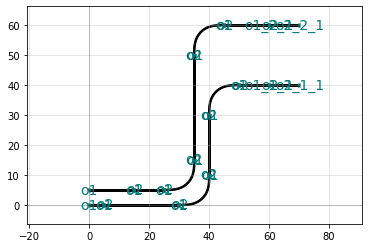

In [38]:
import numpy as np
import gdsfactory as gf

c = gf.Component()
r = c << gf.components.array(
    component=gf.components.straight, rows=2, columns=1, spacing=(0, 20)
)

r.movex(60)
r.movey(40)

lt = c << gf.components.straight(length=15)
lb = c << gf.components.straight(length=5)
lt.movey(5)

ports1 = lt.get_ports_list(orientation=0) + lb.get_ports_list(orientation=0)
ports2 = r.get_ports_list(orientation=180)


dx = 20
p0 = ports1[0].midpoint + (dx, 0)
p1 = (ports1[0].midpoint[0] + dx, ports2[0].midpoint[1])
waypoints = (p0, p1)

routes = gf.routing.get_bundle_from_waypoints(ports1, ports2, waypoints=waypoints)
for route in routes:
    c.add(route.references)
c.plot()

## get_bundle_from_steps

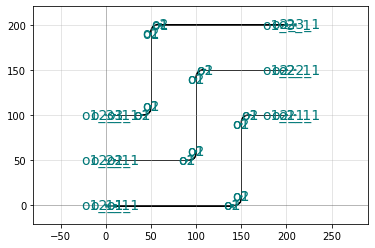

In [39]:
import gdsfactory as gf

c = gf.Component("get_route_from_steps_sample")
w = gf.components.array(
    gf.partial(gf.components.straight, layer=(2, 0)),
    rows=3,
    columns=1,
    spacing=(0, 50),
)

left = c << w
right = c << w
right.move((200, 100))
p1 = left.get_ports_list(orientation=0)
p2 = right.get_ports_list(orientation=180)

routes = gf.routing.get_bundle_from_steps(
    p1,
    p2,
    steps=[{"x": 150}],
)

for route in routes:
    c.add(route.references)

c.plot()

## get_bundle_path_length_match

Sometimes you need to set up a route a bundle of ports that need to keep the same lengths

2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822


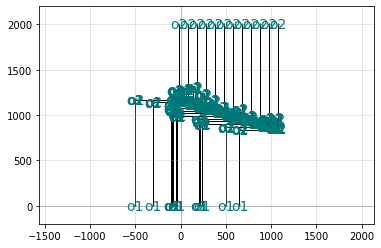

In [40]:
import gdsfactory as gf

c = gf.Component("path_length_match_sample")
dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [gf.Port(f"top_{i}", (xs1[i], 0), 0.5, a1, layer=layer) for i in range(N)]
ports2 = [gf.Port(f"bot_{i}", (xs2[i], dy), 0.5, a2, layer=layer) for i in range(N)]

routes = gf.routing.get_bundle_path_length_match(ports1, ports2)

for route in routes:
    c.add(route.references)
    print(route.length)
c.plot()

### Add extra length

You can also add some extra length to all the routes

2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822


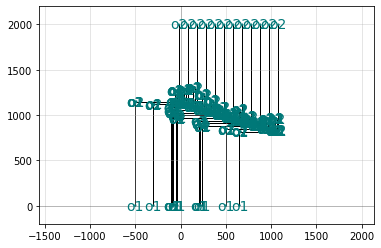

In [41]:
import gdsfactory as gf

c = gf.Component("path_length_match_sample")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [gf.Port(f"top_{i}", (xs1[i], 0), 0.5, a1, layer=layer) for i in range(N)]
ports2 = [gf.Port(f"bot_{i}", (xs2[i], dy), 0.5, a2, layer=layer) for i in range(N)]

routes = gf.routing.get_bundle_path_length_match(ports1, ports2, extra_length=44)
for route in routes:
    c.add(route.references)
    print(route.length)
c.show()  # Klayout show
c.plot()

### increase number of loops

You can also increase the number of loops

3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37


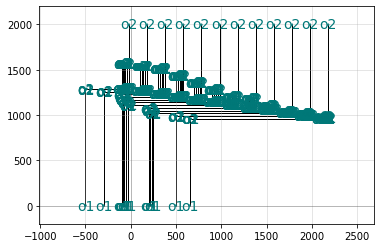

In [42]:
c = gf.Component("path_length_match_sample")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 200.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [gf.Port(f"top_{i}", (xs1[i], 0), 0.5, a1, layer=layer) for i in range(N)]
ports2 = [gf.Port(f"bot_{i}", (xs2[i], dy), 0.5, a2, layer=layer) for i in range(N)]

routes = gf.routing.get_bundle_path_length_match(
    ports1, ports2, nb_loops=2, auto_widen=False
)
for route in routes:
    c.add(route.references)
    print(route.length)
c.plot()

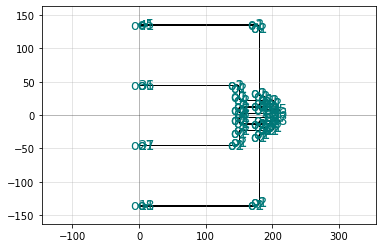

In [43]:
# Problem, sometimes when you do path length matching you need to increase the separation
import gdsfactory as gf

c = gf.Component()
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle_path_length_match(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=30,
    radius=5,
)

for route in routes:
    c.add(route.references)
c.plot()

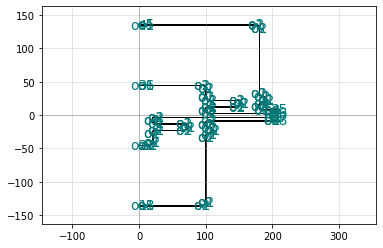

In [44]:
# Solution: increase separation
import gdsfactory as gf

c = gf.Component()
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle_path_length_match(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=80,  # increased
    radius=5,
)

for route in routes:
    c.add(route.references)
c.plot()

## Route to IO (Pads, grating couplers ...)


### Route to electrical pads

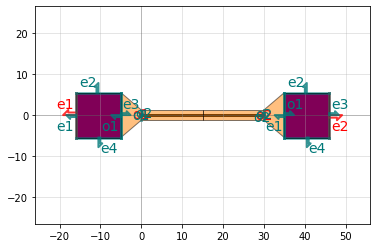

In [45]:
import gdsfactory as gf

mzi = gf.components.straight_heater_metal(length=30)
mzi.plot()

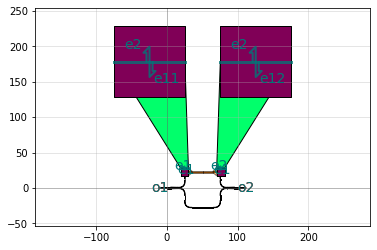

In [46]:
import gdsfactory as gf

mzi = gf.components.mzi_phase_shifter(
    length_x=30, straight_x_top=gf.components.straight_heater_metal_90_90
)
mzi_te = gf.routing.add_electrical_pads_top(component=mzi, layer=(41, 0))
mzi_te.plot()

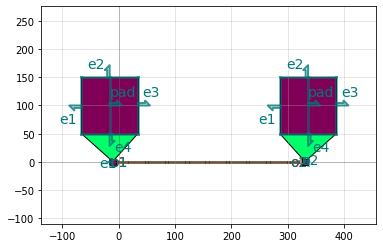

In [47]:
import gdsfactory as gf

hr = gf.components.straight_heater_metal()
cc = gf.routing.add_electrical_pads_shortest(component=hr, layer=(41, 0))
cc.plot()

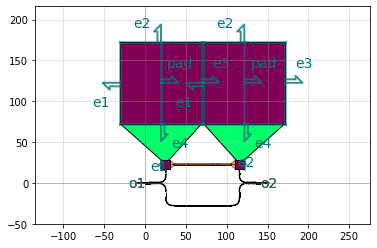

In [48]:
# Problem: Sometimes the shortest path does not work well
import gdsfactory as gf

c = gf.components.mzi_phase_shifter_top_heater_metal(length_x=70)
cc = gf.routing.add_electrical_pads_shortest(component=c, layer=(41, 0))
cc.show()
cc.plot()

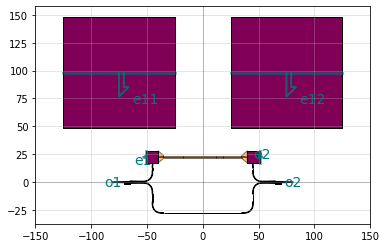

In [49]:
# Solution: you can use define the pads separate and route metal lines to them

c = gf.Component("mzi_with_pads")
c1 = c << gf.components.mzi_phase_shifter_top_heater_metal(length_x=70)
c2 = c << gf.components.pad_array(columns=2)

c2.ymin = c1.ymax + 20
c2.x = 0
c1.x = 0
c.plot()

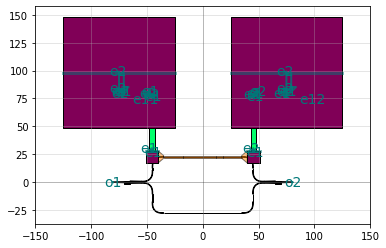

In [50]:
c = gf.Component("mzi_with_pads")
c1 = c << gf.components.mzi_phase_shifter(
    straight_x_top=gf.components.straight_heater_metal_90_90, length_x=70
)
c2 = c << gf.components.pad_array(columns=2)

c2.ymin = c1.ymax + 20
c2.x = 0
c1.x = 0

ports1 = c1.get_ports_list(width=11)
ports2 = c2.get_ports_list()

routes = gf.routing.get_bundle(
    ports1=ports1,
    ports2=ports2,
    cross_section=gf.cross_section.metal1,
    width=5,
    bend=gf.components.wire_corner,
)
for route in routes:
    c.add(route.references)

c.plot()

### Route to Fiber Array

Routing allows you to define routes to optical or electrical IO (grating couplers or electrical pads)

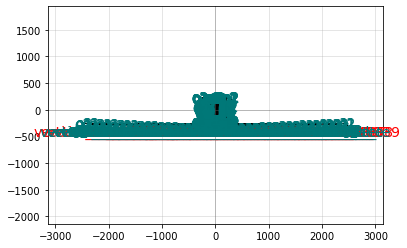

In [51]:
import numpy as np
import gdsfactory as gf
from gdsfactory import LAYER
from gdsfactory import Port


@gf.cell
def big_device(w=400.0, h=400.0, N=16, port_pitch=15.0, layer=LAYER.WG, wg_width=0.5):
    """big component with N ports on each side"""
    component = gf.Component()
    p0 = np.array((0, 0))
    dx = w / 2
    dy = h / 2

    points = [[dx, dy], [dx, -dy], [-dx, -dy], [-dx, dy]]
    component.add_polygon(points, layer=layer)
    port_params = {"layer": layer, "width": wg_width}
    for i in range(N):
        port = Port(
            name="W{}".format(i),
            midpoint=p0 + (-dx, (i - N / 2) * port_pitch),
            orientation=180,
            **port_params,
        )
        component.add_port(port)

    for i in range(N):
        port = Port(
            name="E{}".format(i),
            midpoint=p0 + (dx, (i - N / 2) * port_pitch),
            orientation=0,
            **port_params,
        )
        component.add_port(port)

    for i in range(N):
        port = Port(
            name="N{}".format(i),
            midpoint=p0 + ((i - N / 2) * port_pitch, dy),
            orientation=90,
            **port_params,
        )
        component.add_port(port)

    for i in range(N):
        port = Port(
            name="S{}".format(i),
            midpoint=p0 + ((i - N / 2) * port_pitch, -dy),
            orientation=-90,
            **port_params,
        )
        component.add_port(port)
    return component


component = big_device(N=10)
c = gf.routing.add_fiber_array(component=component, radius=10.0, fanout_length=60.0)
c.plot()

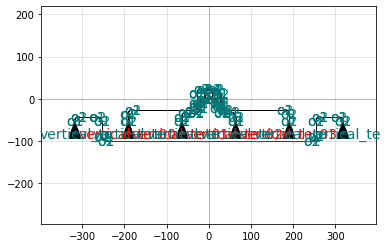

In [52]:
import gdsfactory as gf

c = gf.components.ring_double(width=0.8)
cc = gf.routing.add_fiber_array(component=c, taper_length=150)
cc.plot()

In [53]:
cc.pprint()

settings:
  changed:
    component:
      settings:
        changed: &id001
          width: 0.8
        child: null
        default: &id002
          bend: null
          coupler_ring:
            function: coupler_ring
          cross_section:
            function: cross_section
            settings: {}
          gap: 0.2
          length_x: 0.01
          length_y: 0.01
          radius: 10
          straight:
            function: straight
        full: &id003
          bend: null
          coupler_ring:
            function: coupler_ring
          cross_section:
            function: cross_section
            settings: {}
          gap: 0.2
          length_x: 0.01
          length_y: 0.01
          radius: 10
          straight:
            function: straight
          width: 0.8
        function_name: ring_double
        info: &id004 {}
        info_version: 2
        module: gdsfactory.components.ring_double
        name: ring_double_8de26d73
      version: 0.0.1
    taper_leng

You can also mix and match `TE` and `TM` grating couplers

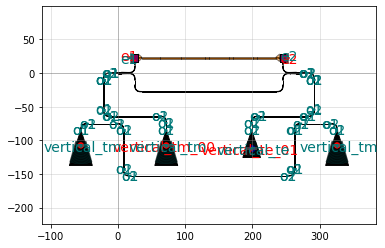

In [54]:
c = gf.components.mzi_phase_shifter()
gcte = gf.components.grating_coupler_te
gctm = gf.components.grating_coupler_tm

cc = gf.routing.add_fiber_array(
    component=c,
    optical_routing_type=2,
    grating_coupler=[gctm, gcte, gctm, gcte],
    radius=20,
)
cc.plot()

### Route to fiber single

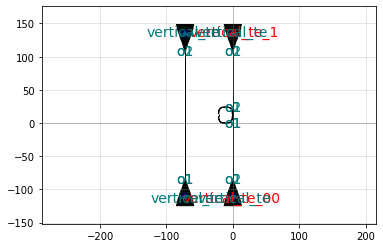

In [55]:
import gdsfactory as gf

c = gf.components.ring_single()
cc = gf.routing.add_fiber_single(component=c)
cc.plot()

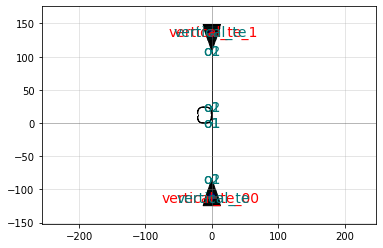

In [56]:
import gdsfactory as gf

c = gf.components.ring_single()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc.plot()

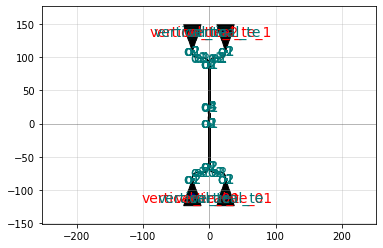

In [57]:
c = gf.components.mmi2x2()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc.plot()

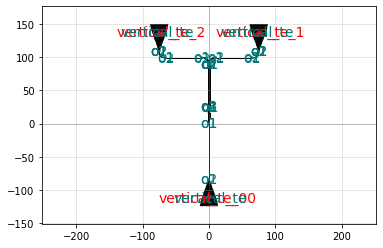

In [58]:
c = gf.components.mmi1x2()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False, fiber_spacing=150)
cc.plot()

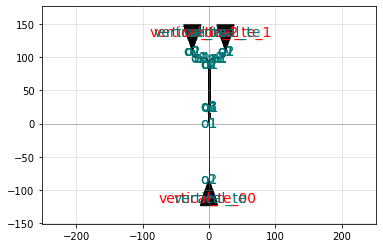

In [59]:
c = gf.components.mmi1x2()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False, fiber_spacing=50)
cc.plot()

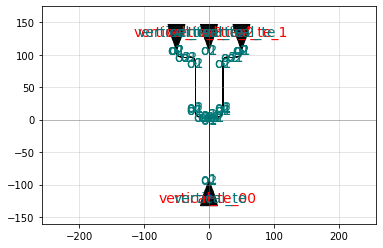

In [60]:
c = gf.components.crossing()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc.plot()

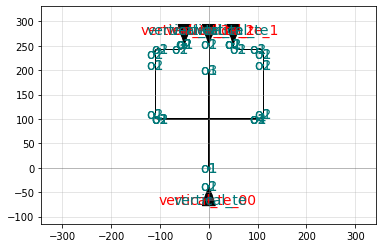

In [61]:
c = gf.components.cross(length=200, width=2, port_type="optical")
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc.plot()

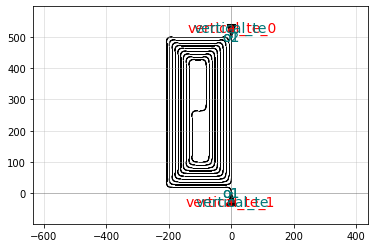

In [62]:
c = gf.components.spiral()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc.plot()